# Лабораторная работа №2. Обучение нейросетевых моделей анализа последовательностей

***Выполнила: Печкина Кристина, 932101гр.***

## Задание №1. RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, SimpleRNN, GRU
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

### Работа с данными

In [5]:
df = pd.read_csv('Yakutsk_weather_19102020_01102012.csv', sep=';', encoding='windows-1251')
df.head()

,LocalTime,T,P0,P,U,DD
0,19.10.2020 17:00,-7.0,745.9,758.2,68.0,Ветер
1,19.10.2020 16:30,-6.0,746.0,758.2,63.0,Ветер
2,19.10.2020 16:00,-5.0,746.0,758.2,58.0,Ветер
3,19.10.2020 15:30,-4.0,746.1,758.2,59.0,Ветер
4,19.10.2020 15:00,-4.0,746.1,758.2,54.0,Ветер


Данные идут в обратном порядке. Поставим их в правильный порядок:

In [9]:
df = df.loc[::-1].set_index(df.index)

In [10]:
df

,LocalTime,T,P0,P,U,DD
0,01.10.2012 00:00,2.0,744.4,756.2,87.0,Ветер
1,01.10.2012 01:00,2.0,744.4,756.2,87.0,Ветер
2,01.10.2012 02:00,2.0,743.6,755.4,87.0,Ветер
3,01.10.2012 03:00,2.0,743.6,755.4,87.0,Ветер
4,01.10.2012 04:00,2.0,742.8,754.6,87.0,Ветер
...,...,...,...,...,...,...
116046,19.10.2020 15:00,-4.0,746.1,758.2,54.0,Ветер
116047,19.10.2020 15:30,-4.0,746.1,758.2,59.0,Ветер
116048,19.10.2020 16:00,-5.0,746.0,758.2,58.0,Ветер
116049,19.10.2020 16:30,-6.0,746.0,758.2,63.0,Ветер


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116051 entries, 0 to 116050
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  116051 non-null  object 
 1   T          116050 non-null  float64
 2   P0         116049 non-null  float64
 3   P          116049 non-null  float64
 4   U          116048 non-null  float64
 5   DD         116048 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.3+ MB


In [12]:
df.isnull().sum()/df.shape[0]

LocalTime    0.000000
T            0.000009
P0           0.000017
P            0.000017
U            0.000026
DD           0.000026
dtype: float64

Есть пропущенные значения. Удалим строки с ними:

In [13]:
df = df.dropna()

In [14]:
df.isnull().sum().sum()

0

In [15]:
df['DD'].value_counts()

Ветер                     99657
Штиль                     16250
Переменное направление      137
Name: DD, dtype: int64

Обработаем данные в столбце DD:

In [16]:
df = pd.get_dummies(df, columns=['DD'], dtype = int)
df.head()

,LocalTime,T,P0,P,U,DD_Ветер,DD_Переменное направление,DD_Штиль
0,01.10.2012 00:00,2.0,744.4,756.2,87.0,1,0,0
1,01.10.2012 01:00,2.0,744.4,756.2,87.0,1,0,0
2,01.10.2012 02:00,2.0,743.6,755.4,87.0,1,0,0
3,01.10.2012 03:00,2.0,743.6,755.4,87.0,1,0,0
4,01.10.2012 04:00,2.0,742.8,754.6,87.0,1,0,0


In [17]:
df.isnull().sum().sum()

0

In [18]:
min_max_scaler = MinMaxScaler()

df_temp = df['T'].values
df_temp = min_max_scaler.fit_transform(df_temp.reshape(-1, 1))

In [19]:
print(df_temp.shape)
df_temp = df_temp.flatten()
print(df_temp.shape)

(116044, 1)
(116044,)


Разделим данные на тренировочную, валидационную и тестовую выборку:

In [20]:
window = 15

n_samples=df_temp.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.1*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  81220 Validation =  11603 Test =  23206


In [21]:
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

In [22]:
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=df_temp[i+j]
  y_train[i]=df_temp[i+window]

for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=df_temp[n_train_samples+i+j]
  y_val[i]=df_temp[n_train_samples+i+window]

for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=df_temp[n_train_samples+n_val_samples+i+j]
  y_test[i]=df_temp[n_train_samples+n_val_samples+i+window]

### Создание моделей. Base Model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:

1. Слой SimpleRNN, 10 нейронов, функция активации - ReLU
2. 1 нейрон, функция активации - Linear

In [69]:
simple_rnn_model = Sequential(
    [
        layers.SimpleRNN(10,activation='relu',input_shape=(window,1)),
        layers.Dense(1, activation = 'linear')
    ]
)
simple_rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 131 (524.00 Byte)
Trainable params: 131 (524.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [71]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Зададим количество объектов в одном батче, равное 30, и число эпох, равное 40:

In [72]:
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=30,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
2701/2708 [============================>.] - ETA: 0s - loss: 0.0047 - mae: 0.0197
Epoch 1: val_mae improved from inf to 0.00767, saving model to simple_rnn-temperature-01-0.008.hdf5
2708/2708 [==============================] - 17s 6ms/step - loss: 0.0047 - mae: 0.0196 - val_loss: 1.0940e-04 - val_mae: 0.0077
Epoch 2/40
  38/2708 [..............................] - ETA: 11s - loss: 1.3018e-04 - mae: 0.0084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2700/2708 [============================>.] - ETA: 0s - loss: 1.3009e-04 - mae: 0.0081
Epoch 2: val_mae improved from 0.00767 to 0.00649, saving model to simple_rnn-temperature-02-0.006.hdf5
2708/2708 [==============================] - 15s 6ms/step - loss: 1.3002e-04 - mae: 0.0081 - val_loss: 8.8338e-05 - val_mae: 0.0065
Epoch 3/40
2707/2708 [============================>.] - ETA: 0s - loss: 1.2408e-04 - mae: 0.0080
Epoch 3: val_mae did not improve from 0.00649
2708/2708 [==============================] - 16s 6ms/step - loss: 1.2408e-04 - mae: 0.0080 - val_loss: 8.7932e-05 - val_mae: 0.0065
Epoch 4/40
2702/2708 [============================>.] - ETA: 0s - loss: 1.2006e-04 - mae: 0.0078
Epoch 4: val_mae improved from 0.00649 to 0.00631, saving model to simple_rnn-temperature-04-0.006.hdf5
2708/2708 [==============================] - 16s 6ms/step - loss: 1.2010e-04 - mae: 0.0078 - val_loss: 8.5095e-05 - val_mae: 0.0063
Epoch 5/40
2705/2708 [============================>.] - ETA: 0s - loss

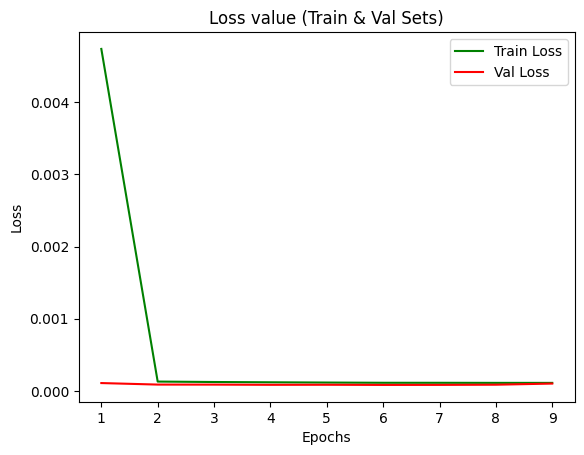

In [73]:
loss_function = simple_rnn_model_history.history['loss']
val_loss_function = simple_rnn_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

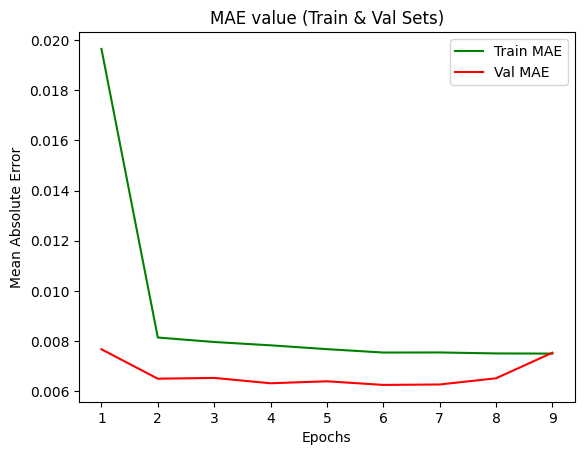

In [74]:
mae_function = simple_rnn_model_history.history['mae']
val_mae_function = simple_rnn_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [75]:
y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

726/726 [==============================] - 2s 2ms/step
MSE =  0.0  K degrees
MAE =  0.008  K degrees
R2-score =  0.998


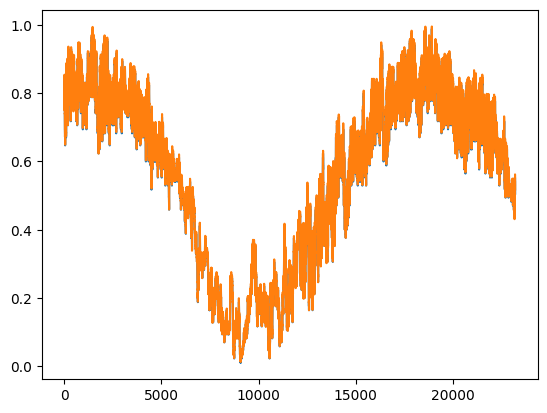

In [76]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

Добавим остальные данные для обучения модели:

In [32]:
df_all = df.drop('LocalTime', axis=1)
df_all = min_max_scaler.fit_transform(df_all)

In [33]:
print(df_all.shape)
df_all = df_all.flatten()
print(df_all.shape)

(116044, 7)
(812308,)


In [34]:
window_all = 20

n_samples_all=df_all.shape[0]-window_all
n_train_samples_all=round(0.7*n_samples_all)
n_val_samples_all=round(0.1*n_samples_all)
n_test_samples_all=n_samples_all-n_train_samples_all-n_val_samples_all
print('Train = ',n_train_samples_all,'Validation = ',n_val_samples_all,'Test = ',n_test_samples_all)

Train =  568602 Validation =  81229 Test =  162457


In [35]:
X_train_all=np.zeros((n_train_samples_all,window_all,7))
y_train_all=np.zeros(n_train_samples_all)

X_val_all=np.zeros((n_val_samples_all,window_all,7))
y_val_all=np.zeros(n_val_samples_all)

X_test_all=np.zeros((n_test_samples_all,window_all,7))
y_test_all=np.zeros(n_test_samples_all)

In [36]:
for i in range(n_train_samples_all):
  for j in range(window_all):
    X_train_all[i,j]=df_all[i+j]
  y_train_all[i]=df_all[i+window_all]

for i in range(n_val_samples_all):
  for j in range(window_all):
    X_val_all[i,j]=df_all[n_train_samples_all+i+j]
  y_val_all[i]=df_all[n_train_samples_all+i+window_all]

for i in range(n_test_samples_all):
  for j in range(window_all):
    X_test_all[i,j]=df_all[n_train_samples_all+n_val_samples_all+i+j]
  y_test_all[i]=df_all[n_train_samples_all+n_val_samples_all+i+window_all]

### Second Model

Создадим вторую модель нейронной сети, состоящую из 2 слоёв:

1. Слой SimpleRNN, 20 нейронов, функция активации - ReLU
2. 1 нейрон, функция активации - Linear

In [37]:
simple_rnn_all_model = Sequential(
    [
        layers.SimpleRNN(20,activation='relu',input_shape=(window_all,7)),
        layers.Dense(1, activation = 'linear')
    ]
)
simple_rnn_all_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                560       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 581 (2.27 KB)
Trainable params: 581 (2.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
simple_rnn_all_model.compile(loss='mse',optimizer='adam',metrics='mae')

In [41]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Увеличим количество объектов в одном батче в 10 раз:

In [42]:
simple_rnn_all_model_history = simple_rnn_all_model.fit(X_train_all,y_train_all,batch_size=300,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val_all,y_val_all))

Epoch 1/40
1889/1896 [============================>.] - ETA: 0s - loss: 0.0158 - mae: 0.0627
Epoch 1: val_mae improved from inf to 0.04675, saving model to simple_rnn-temperature-01-0.047.hdf5
1896/1896 [==============================] - 19s 10ms/step - loss: 0.0157 - mae: 0.0627 - val_loss: 0.0125 - val_mae: 0.0467
Epoch 2/40
  15/1896 [..............................] - ETA: 14s - loss: 0.0137 - mae: 0.0551

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1894/1896 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0525
Epoch 2: val_mae did not improve from 0.04675
1896/1896 [==============================] - 15s 8ms/step - loss: 0.0137 - mae: 0.0525 - val_loss: 0.0126 - val_mae: 0.0513
Epoch 3/40
1895/1896 [============================>.] - ETA: 0s - loss: 0.0132 - mae: 0.0496
Epoch 3: val_mae improved from 0.04675 to 0.04485, saving model to simple_rnn-temperature-03-0.045.hdf5
1896/1896 [==============================] - 15s 8ms/step - loss: 0.0132 - mae: 0.0496 - val_loss: 0.0119 - val_mae: 0.0448
Epoch 4/40
1893/1896 [============================>.] - ETA: 0s - loss: 0.0130 - mae: 0.0483
Epoch 4: val_mae improved from 0.04485 to 0.04241, saving model to simple_rnn-temperature-04-0.042.hdf5
1896/1896 [==============================] - 15s 8ms/step - loss: 0.0130 - mae: 0.0483 - val_loss: 0.0117 - val_mae: 0.0424
Epoch 5/40
1896/1896 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0471
Epoch 5: val_

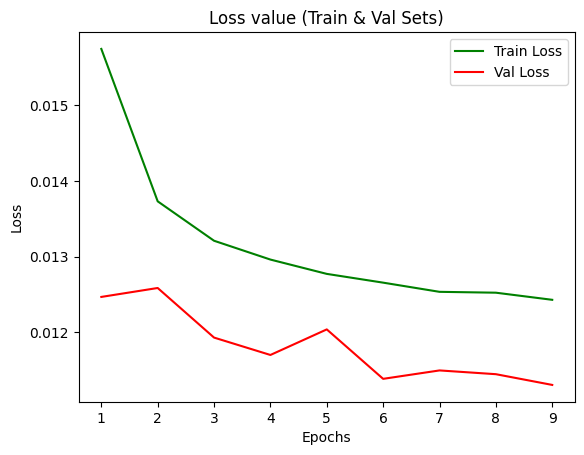

In [43]:
loss_function = simple_rnn_all_model_history.history['loss']
val_loss_function = simple_rnn_all_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

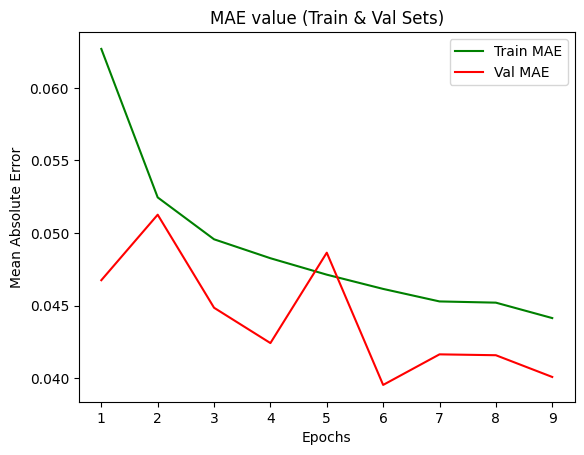

In [44]:
mae_function = simple_rnn_all_model_history.history['mae']
val_mae_function = simple_rnn_all_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [55]:
min_max_scaler.fit(y_train_all.reshape(-1, 1))
y_pred = simple_rnn_all_model.predict(X_test_all)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test_all.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

5077/5077 [==============================] - 15s 3ms/step
MSE =  0.006  K degrees
MAE =  0.031  K degrees
R2-score =  0.951


In [46]:
x = X_test_all[2]
x = x.reshape((1,) + x.shape)
y_pred = simple_rnn_all_model.predict(x)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
truth = y_test_all[2]
truth_inv = min_max_scaler.inverse_transform(truth.reshape(-1, 1))
print('Предсказанная температура:', y_pred_inv[0, 0])
print('Реальная температура:', truth_inv[0, 0])

1/1 [==============================] - 0s 27ms/step
Предсказанная температура: 0.31073916
Реальная температура: 0.32188841201716656


## Задание №2. GRU

### Создание моделей. Base Model

Создадим базовую модель нейронной сети, состоящую из 2 слоёв:

1. Слой GRU, 10 нейронов
2. 1 нейрон, функция активации - Linear

In [47]:
gru_model = Sequential(
    [
        layers.GRU(10,input_shape=(window,1)),
        layers.Dense(1, activation = 'linear')
    ]
)
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                390       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 401 (1.57 KB)
Trainable params: 401 (1.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
gru_model.compile(optimizer='adam',loss='mse',metrics='mae')

In [49]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('gru-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Зададим количество объектов в одном батче, равное 30, и число эпох, равное 40:

In [50]:
gru_model_history = gru_model.fit(X_train,y_train,batch_size=30,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
2708/2708 [==============================] - ETA: 0s - loss: 0.0046 - mae: 0.0252
Epoch 1: val_mae improved from inf to 0.00760, saving model to gru-temperature-01-0.008.hdf5
2708/2708 [==============================] - 30s 10ms/step - loss: 0.0046 - mae: 0.0252 - val_loss: 1.1781e-04 - val_mae: 0.0076
Epoch 2/40
  14/2708 [..............................] - ETA: 23s - loss: 1.5217e-04 - mae: 0.0090

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2708/2708 [==============================] - ETA: 0s - loss: 1.4430e-04 - mae: 0.0085
Epoch 2: val_mae improved from 0.00760 to 0.00632, saving model to gru-temperature-02-0.006.hdf5
2708/2708 [==============================] - 27s 10ms/step - loss: 1.4430e-04 - mae: 0.0085 - val_loss: 8.8115e-05 - val_mae: 0.0063
Epoch 3/40
2706/2708 [============================>.] - ETA: 0s - loss: 1.2011e-04 - mae: 0.0077
Epoch 3: val_mae improved from 0.00632 to 0.00616, saving model to gru-temperature-03-0.006.hdf5
2708/2708 [==============================] - 26s 10ms/step - loss: 1.2011e-04 - mae: 0.0077 - val_loss: 8.3616e-05 - val_mae: 0.0062
Epoch 4/40
2708/2708 [==============================] - ETA: 0s - loss: 1.1422e-04 - mae: 0.0076
Epoch 4: val_mae did not improve from 0.00616
2708/2708 [==============================] - 25s 9ms/step - loss: 1.1422e-04 - mae: 0.0076 - val_loss: 1.0017e-04 - val_mae: 0.0077
Epoch 5/40
2706/2708 [============================>.] - ETA: 0s - loss: 1.1178e-04

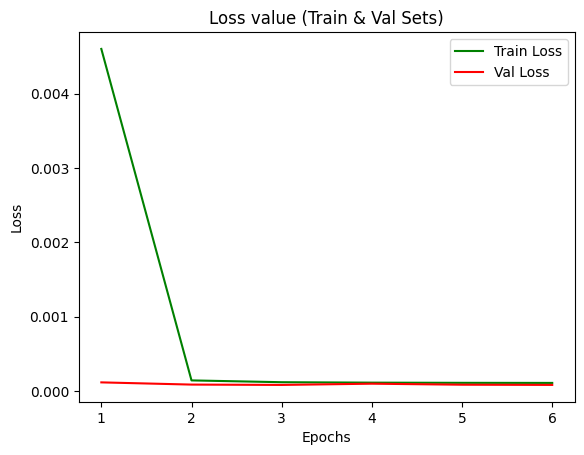

In [51]:
loss_function = gru_model_history.history['loss']
val_loss_function = gru_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

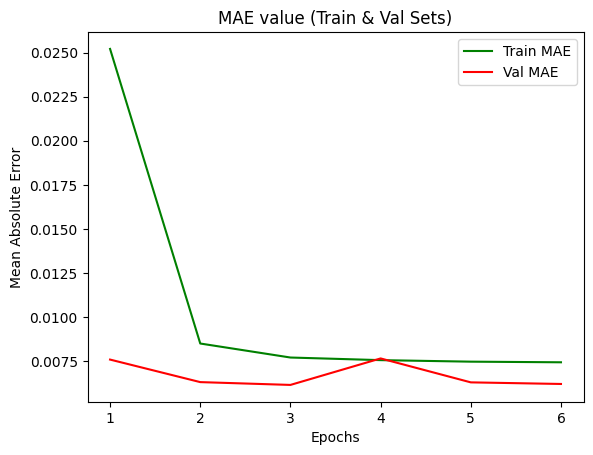

In [52]:
mae_function = gru_model_history.history['mae']
val_mae_function = gru_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [53]:
y_pred = gru_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

726/726 [==============================] - 3s 3ms/step
MSE =  0.0  K degrees
MAE =  0.007  K degrees
R2-score =  0.999


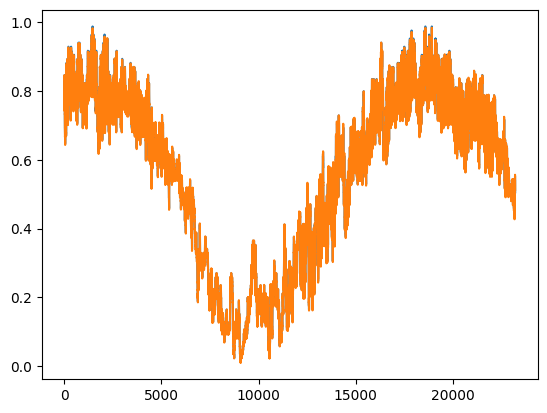

In [54]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

#### Second Model

Создадим вторую модель нейронной сети, состоящую из 2 слоёв:

1. Слой GRU, 50 нейронов
2. 1 нейрон, функция активации - Linear

In [99]:
gru_all_model = Sequential(
    [
        layers.GRU(50,input_shape=(window_all,7)),
        layers.Dense(1, activation = 'linear')
    ]
)
gru_all_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50)                8850      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 8901 (34.77 KB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Изменим процедуру оптимизации на SGD:

In [100]:
gru_all_model.compile(loss='mse',optimizer='SGD',metrics='mae')

In [101]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('gru-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Увеличим количество объектов в одном батче в 5 раз:

In [102]:
gru_all_model_history = gru_all_model.fit(X_train_all,y_train_all,batch_size=150,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val_all,y_val_all))

Epoch 1/40
3790/3791 [============================>.] - ETA: 0s - loss: 0.0975 - mae: 0.2633
Epoch 1: val_mae improved from inf to 0.23557, saving model to gru-temperature-01-0.236.hdf5
3791/3791 [==============================] - 86s 22ms/step - loss: 0.0975 - mae: 0.2633 - val_loss: 0.0796 - val_mae: 0.2356
Epoch 2/40
3789/3791 [============================>.] - ETA: 0s - loss: 0.0792 - mae: 0.2326
Epoch 2: val_mae improved from 0.23557 to 0.22266, saving model to gru-temperature-02-0.223.hdf5
3791/3791 [==============================] - 84s 22ms/step - loss: 0.0792 - mae: 0.2326 - val_loss: 0.0725 - val_mae: 0.2227
Epoch 3/40
3789/3791 [============================>.] - ETA: 0s - loss: 0.0760 - mae: 0.2261
Epoch 3: val_mae improved from 0.22266 to 0.22149, saving model to gru-temperature-03-0.221.hdf5
3791/3791 [==============================] - 100s 26ms/step - loss: 0.0760 - mae: 0.2261 - val_loss: 0.0715 - val_mae: 0.2215
Epoch 4/40
3790/3791 [============================>.] - ET

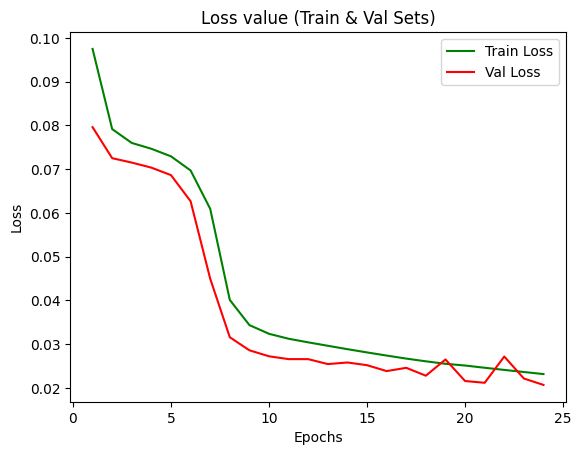

In [103]:
loss_function = gru_all_model_history.history['loss']
val_loss_function = gru_all_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

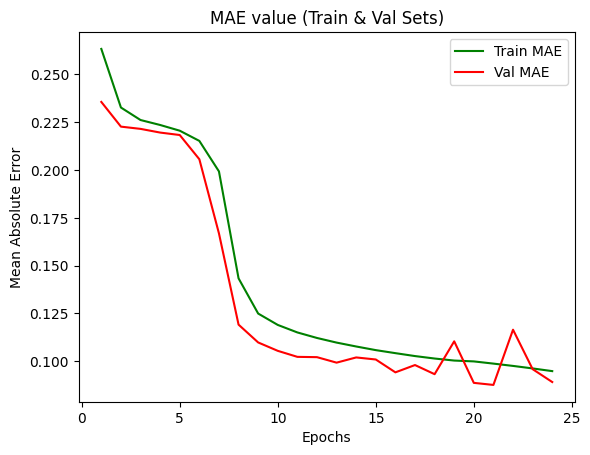

In [104]:
mae_function = gru_all_model_history.history['mae']
val_mae_function = gru_all_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [105]:
min_max_scaler.fit(y_train_all.reshape(-1, 1))
y_pred = gru_all_model.predict(X_test_all)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test_all.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

5077/5077 [==============================] - 21s 4ms/step
MSE =  0.014  K degrees
MAE =  0.078  K degrees
R2-score =  0.887


In [107]:
x = X_test_all[2]
x = x.reshape((1,) + x.shape)
y_pred = gru_all_model.predict(x)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
truth = y_test_all[2]
truth_inv = min_max_scaler.inverse_transform(truth.reshape(-1, 1))
print('Предсказанная температура:', y_pred_inv[0, 0])
print('Реальная температура:', truth_inv[0, 0])

1/1 [==============================] - 0s 38ms/step
Предсказанная температура: 0.35199025
Реальная температура: 0.32188841201716656


## Задание №3. Стек двух слоёв с GRU

### Создание моделей. Base Model

Создадим базовую модель нейронной сети, состоящую из 3 слоёв:

1. Слой GRU, 10 нейронов, функция активации - Relu
2. Слой GRU, 10 нейронов, функция активации - Relu
3. 1 нейрон, функция активации - Linear

In [109]:
grugru_model = Sequential(
    [
        layers.GRU(10, activation='relu', input_shape=(window,1), return_sequences=True),
        layers.GRU(10, activation='relu'),
        layers.Dense(1, activation = 'linear')
    ]
)
grugru_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 15, 10)            390       
                                                                 
 gru_6 (GRU)                 (None, 10)                660       
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1061 (4.14 KB)
Trainable params: 1061 (4.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
grugru_model.compile(optimizer='adam',loss='mse',metrics='mae')

In [112]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('grugru-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Зададим количество объектов в одном батче, равное 30, и число эпох, равное 40:

In [113]:
grugru_model_history = grugru_model.fit(X_train,y_train,batch_size=30,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
2705/2708 [============================>.] - ETA: 0s - loss: 0.0042 - mae: 0.0190
Epoch 1: val_mae improved from inf to 0.00671, saving model to grugru-temperature-01-0.007.hdf5
2708/2708 [==============================] - 48s 17ms/step - loss: 0.0042 - mae: 0.0190 - val_loss: 9.1987e-05 - val_mae: 0.0067
Epoch 2/40
   7/2708 [..............................] - ETA: 52s - loss: 1.2954e-04 - mae: 0.0085

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2707/2708 [============================>.] - ETA: 0s - loss: 1.2376e-04 - mae: 0.0080
Epoch 2: val_mae improved from 0.00671 to 0.00635, saving model to grugru-temperature-02-0.006.hdf5
2708/2708 [==============================] - 43s 16ms/step - loss: 1.2375e-04 - mae: 0.0080 - val_loss: 8.4619e-05 - val_mae: 0.0064
Epoch 3/40
2706/2708 [============================>.] - ETA: 0s - loss: 1.1812e-04 - mae: 0.0078
Epoch 3: val_mae did not improve from 0.00635
2708/2708 [==============================] - 44s 16ms/step - loss: 1.1810e-04 - mae: 0.0078 - val_loss: 8.7303e-05 - val_mae: 0.0066
Epoch 4/40
2706/2708 [============================>.] - ETA: 0s - loss: 1.1737e-04 - mae: 0.0078
Epoch 4: val_mae improved from 0.00635 to 0.00617, saving model to grugru-temperature-04-0.006.hdf5
2708/2708 [==============================] - 43s 16ms/step - loss: 1.1738e-04 - mae: 0.0078 - val_loss: 8.3812e-05 - val_mae: 0.0062
Epoch 5/40
2707/2708 [============================>.] - ETA: 0s - loss: 1.1

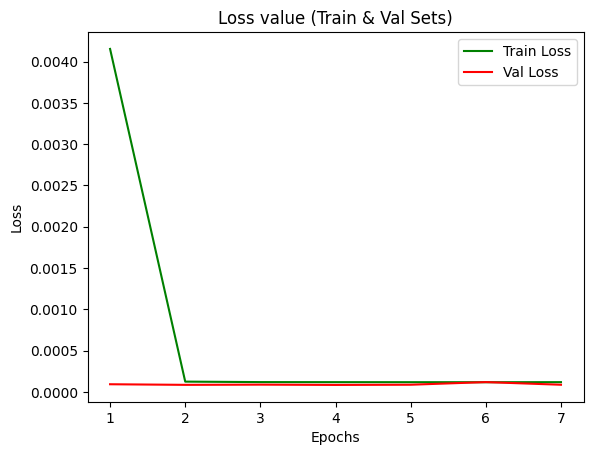

In [114]:
loss_function = grugru_model_history.history['loss']
val_loss_function = grugru_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

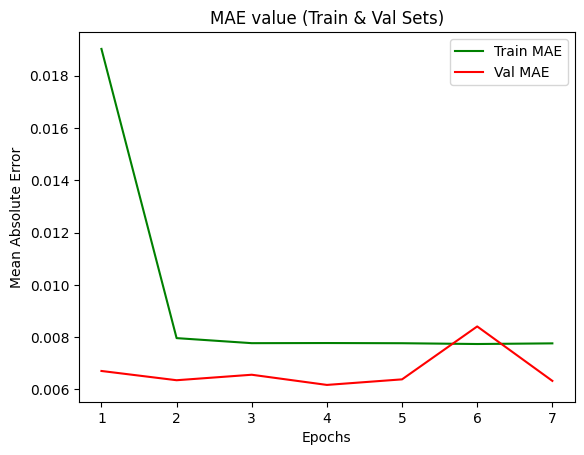

In [115]:
mae_function = grugru_model_history.history['mae']
val_mae_function = grugru_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [116]:
y_pred = grugru_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

726/726 [==============================] - 3s 4ms/step
MSE =  0.0  K degrees
MAE =  0.007  K degrees
R2-score =  0.999


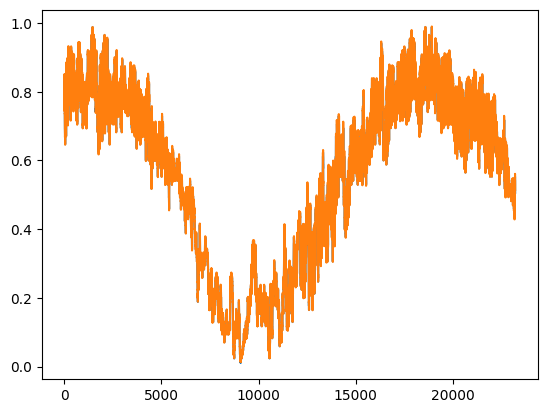

In [117]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

### Second Model

Создадим вторую модель нейронной сети, состоящую из 2 слоёв:

1. Слой GRU, 30 нейронов, функция активации - Relu
2. Dropout(0.1)
3. Слой GRU, 20 нейронов, функция активации - Relu
4. 1 нейрон, функция активации - Linear

In [129]:
grugru_all_model = Sequential(
    [
        layers.GRU(30, activation='relu', input_shape=(window_all,7), return_sequences=True),
        layers.Dropout(0.1),
        layers.GRU(20, activation='relu'),
        layers.Dense(1, activation = 'linear')
    ]
)
grugru_all_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 20, 30)            3510      
                                                                 
 dropout_2 (Dropout)         (None, 20, 30)            0         
                                                                 
 gru_12 (GRU)                (None, 20)                3120      
                                                                 
 dense_12 (Dense)            (None, 1)                 21        
                                                                 
Total params: 6651 (25.98 KB)
Trainable params: 6651 (25.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Изменим процедуру оптимизации на SGD:

In [130]:
grugru_all_model.compile(loss='mse',optimizer='SGD',metrics='mae')

In [131]:
early_stop = EarlyStopping(monitor='val_mae',patience=3,mode='min',verbose=1)
checkpoint = ModelCheckpoint('gru-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

Увеличим количество объектов в одном батче до 400:

In [132]:
grugru_all_model_history = grugru_all_model.fit(X_train_all,y_train_all,batch_size=400,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val_all,y_val_all))

Epoch 1/40
1421/1422 [============================>.] - ETA: 0s - loss: 0.1158 - mae: 0.2914
Epoch 1: val_mae improved from inf to 0.26106, saving model to gru-temperature-01-0.261.hdf5
1422/1422 [==============================] - 72s 49ms/step - loss: 0.1158 - mae: 0.2914 - val_loss: 0.0961 - val_mae: 0.2611
Epoch 2/40
1422/1422 [==============================] - ETA: 0s - loss: 0.0963 - mae: 0.2601
Epoch 2: val_mae improved from 0.26106 to 0.24470, saving model to gru-temperature-02-0.245.hdf5
1422/1422 [==============================] - 76s 53ms/step - loss: 0.0963 - mae: 0.2601 - val_loss: 0.0847 - val_mae: 0.2447
Epoch 3/40
1422/1422 [==============================] - ETA: 0s - loss: 0.0883 - mae: 0.2465
Epoch 3: val_mae improved from 0.24470 to 0.23537, saving model to gru-temperature-03-0.235.hdf5
1422/1422 [==============================] - 87s 61ms/step - loss: 0.0883 - mae: 0.2465 - val_loss: 0.0775 - val_mae: 0.2354
Epoch 4/40
1421/1422 [============================>.] - ETA

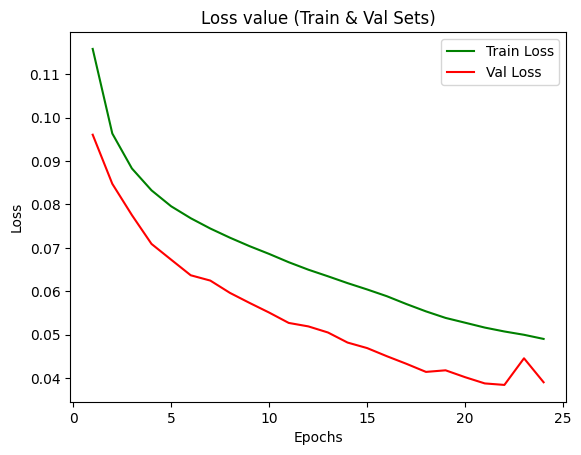

In [133]:
loss_function = grugru_all_model_history.history['loss']
val_loss_function = grugru_all_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('Loss value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train Loss')
plt.plot(epochs,val_loss_function,color='red',label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

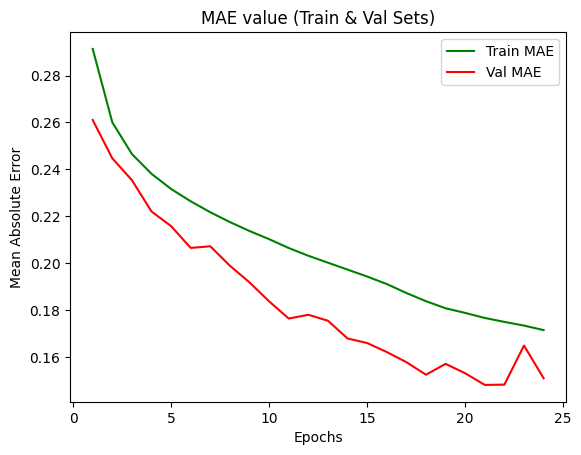

In [134]:
mae_function = grugru_all_model_history.history['mae']
val_mae_function = grugru_all_model_history.history['val_mae']

epochs=range(1,len(loss_function)+1)

plt.title('MAE value (Train & Val Sets)')
plt.plot(epochs,mae_function,color='green',label='Train MAE')
plt.plot(epochs,val_mae_function,color='red',label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [135]:
min_max_scaler.fit(y_train_all.reshape(-1, 1))
y_pred = grugru_all_model.predict(X_test_all)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test_all.reshape(-1,1))
print('MSE = ',round(mean_squared_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),' K degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))

5077/5077 [==============================] - 35s 7ms/step
MSE =  0.037  K degrees
MAE =  0.153  K degrees
R2-score =  0.712


In [136]:
x = X_test_all[2]
x = x.reshape((1,) + x.shape)
y_pred = grugru_all_model.predict(x)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
truth = y_test_all[2]
truth_inv = min_max_scaler.inverse_transform(truth.reshape(-1, 1))
print('Предсказанная температура:', y_pred_inv[0, 0])
print('Реальная температура:', truth_inv[0, 0])

1/1 [==============================] - 0s 28ms/step
Предсказанная температура: 0.39586365
Реальная температура: 0.32188841201716656


### Вывод

Набор данных Погода в Якутстке содержал пропущенные значения, строки с ними были удалены. Значения в столбце DD были преобразованы с помощью функции get_dummies.Для обучения базовых моделей использовался только признак T, для обучения вторых моделей использовались все признаки, кроме LocalTime. Датасет был разделен на 3 части: тренировочную (70%), тестовую (20%) и валидационную (10%).

Оценка качества регрессоров происходила по следующим метрикам: MSE, MAE и R2.

Среди трёх моделей регрессоров, которые обучались только на признаке T, лучше всего сработали модели с GRU и со стеком двух слоёв с GRU. У них одинаковые значения метрик: MSE = 0.0, MAE = 0.007 и R2 = 0.999.

Среди трёх моделей регрессоров, которые обучались только на всех признаках, лучше всего сработала модель с SimpleRNN. Значения метрик: MSE = 0.006, MAE = 0.031 и R2 = 0.951.